# GNN for Classification: Neighbor Aggregation Illustration

This notebook demonstrates GNN's power using a clean synthetic setup where the **target explicitly depends on neighbor features**.

## The Key Insight

GNNs excel when the prediction target depends on information from graph neighbors:

$$P(y_i = 1) = \sigma\left(\alpha \cdot f(x_i) + \beta \cdot g\left(\{x_j : j \in \mathcal{N}(i)\}\right)\right)$$

where:
- $x_i$ = own node features
- $\mathcal{N}(i)$ = neighbors of node $i$
- $\alpha$ = weight on own features (baselines can learn this)
- $\beta$ = weight on neighbor features (only GNN can learn this)
- $\sigma$ = sigmoid function

When $\beta > \alpha$, GNN has a structural advantage.

## Transductive vs Inductive Learning

This notebook uses **transductive learning** on a single graph:
- One graph with all nodes
- Split nodes into train/test masks
- Train on labeled subset, predict on held-out nodes
- GNNs excel here because the graph structure is shared

## Financial Interpretation

This models binary classification scenarios like:
- **Default prediction**: Whether a company defaults depends on its counterparties' health
- **Fraud detection**: Fraudulent accounts cluster together in transaction networks
- **Sector distress**: Whether a stock enters distress depends on sector peers

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from typing import Dict, Tuple
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torch_geometric.nn import GCNConv, GATConv

SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)

print(f"PyTorch: {torch.__version__}")

PyTorch: 2.2.2


## 1. Synthetic Data Generation

We construct a synthetic dataset specifically designed to demonstrate when and why GNNs outperform traditional ML models for **binary classification**. The key insight is that **GNNs have an advantage when the class label depends on neighborhood information**.

### 1.1 Graph Construction: Stochastic Block Model (SBM)

We use the **Stochastic Block Model** to generate a graph with realistic community structure, mimicking how financial assets cluster into sectors.

**Definition**: Given $n$ nodes partitioned into $K$ communities, the SBM generates edges independently:

$$P(A_{ij} = 1) = \begin{cases} p_{\text{in}} & \text{if } c_i = c_j \text{ (same community)} \\ p_{\text{out}} & \text{if } c_i \neq c_j \text{ (different communities)} \end{cases}$$

where:
- $A_{ij}$ is the adjacency matrix entry
- $c_i$ is the community assignment of node $i$
- $p_{\text{in}} > p_{\text{out}}$ ensures dense within-community connections

**Parameters used:**
- $n = 300$ nodes (assets)
- $K = 5$ communities (sectors)
- $p_{\text{in}} = 0.3$ (30% chance of edge within sector)
- $p_{\text{out}} = 0.02$ (2% chance of edge across sectors)

### 1.2 Node Features

Each node $i$ has a feature vector $\mathbf{x}_i \in \mathbb{R}^{5}$ drawn i.i.d. from a standard normal:

$$\mathbf{x}_i \sim \mathcal{N}(\mathbf{0}, \mathbf{I}_{5})$$

### 1.3 Target Generation: Binary Classification

We first compute a continuous latent score using **all features** from both self and neighbors:

$$z_i = \alpha \cdot \tilde{s}_i + \beta \cdot \tilde{h}_i$$

where:
- $\tilde{s}_i$ = scaled sum of own features (own signal)
- $\tilde{h}_i$ = scaled sum of neighbor-averaged features (neighbor signal)

**Own signal** (sum over all features):
$$s_i = \sum_{k=0}^{4} x_i^{(k)} = \mathbf{1}^\top \mathbf{x}_i$$

**Neighbor signal** (sum of mean neighbor features):
$$h_i = \sum_{k=0}^{4} \bar{x}_{\mathcal{N}(i)}^{(k)} = \mathbf{1}^\top \bar{\mathbf{x}}_{\mathcal{N}(i)}$$

**Binary label** via thresholding:
$$y_i = \mathbf{1}[z_i > 0]$$

This creates balanced classes (approximately 50% positive).

**Parameters used:**
- $\alpha = 0.3$ (own signal weight)
- $\beta = 0.7$ (neighbor signal weight)

This means **~84% of signal** comes from neighbors ($0.7^2 / (0.3^2 + 0.7^2) = 0.84$).

### 1.4 Pseudocode: Data Generation Algorithm

```
Algorithm: Generate Synthetic GNN Classification Dataset
─────────────────────────────────────────────────────────

Input:
    n         : number of nodes (e.g., 300)
    K         : number of communities (e.g., 5)
    d         : number of features per node (e.g., 5)
    p_in      : within-community edge probability (e.g., 0.3)
    p_out     : across-community edge probability (e.g., 0.02)
    α         : own-signal weight (e.g., 0.3)
    β         : neighbor-signal weight (e.g., 0.7)

Output:
    X         : node feature matrix (n × d)
    A         : adjacency matrix (n × n)
    y         : binary labels (n,) ∈ {0, 1}

─────────────────────────────────────────────────────────

Step 1: Assign nodes to communities
    for i = 1 to n:
        c[i] ← floor((i-1) / (n/K))

Step 2: Generate SBM adjacency matrix
    A ← zeros(n, n)
    for i = 1 to n:
        for j = i+1 to n:
            if c[i] == c[j]:
                p ← p_in
            else:
                p ← p_out
            if random() < p:
                A[i,j] ← 1
                A[j,i] ← 1

Step 3: Generate node features
    X ← random_normal(n, d)

Step 4: Compute neighbor mean features (for all dimensions)
    for i = 1 to n:
        neighbors ← {j : A[i,j] = 1}
        if |neighbors| > 0:
            neighbor_mean[i] ← mean(X[j, :] for j in neighbors)
        else:
            neighbor_mean[i] ← X[i, :]

Step 5: Compute own and neighbor signals (sum over all features)
    for i = 1 to n:
        s[i] ← sum(X[i, :])
        h[i] ← sum(neighbor_mean[i, :])

Step 6: Scale signals to unit variance
    s̃ ← s / std(s)
    h̃ ← h / std(h)

Step 7: Generate latent score and binary label
    for i = 1 to n:
        z[i] ← α * s̃[i] + β * h̃[i]
        y[i] ← 1 if z[i] > 0 else 0

Step 8: Create train/test masks
    indices ← random_permutation(1 to n)
    train_mask ← indices[1 : 0.7*n]
    test_mask  ← indices[0.7*n+1 : n]

return X, A, y, train_mask, test_mask
```

### 1.5 Why This Design Creates GNN Advantage

| Model | Can access $\mathbf{x}_i$? | Can access $\{\mathbf{x}_j : j \in \mathcal{N}(i)\}$? | Learnable signal |
|-------|-------------------|---------------------------------------------|------------------|
| LogReg/MLP | Yes | **No** | Only $\alpha \cdot \tilde{s}_i$ (~16% of signal) |
| GCN/GAT | Yes | **Yes** (via message passing) | Both components (~100% of signal) |

The baseline models are **structurally limited** - they cannot access neighbor features regardless of model capacity.

In [2]:
def generate_sbm_graph(n_nodes: int, 
                       n_communities: int, 
                       p_in: float, 
                       p_out: float, 
                       seed: int = 42) -> np.ndarray:
    """
    Generate Stochastic Block Model graph.
    
    Args:
        n_nodes: total number of nodesso 
        n_communities: number of communities/sectors
        p_in: probability of edge within community
        p_out: probability of edge across communities
    
    Returns:
        adj_matrix: (n_nodes, n_nodes) adjacency matrix
        community_labels: (n_nodes,) community assignment
    """
    np.random.seed(seed)
    
    # Assign nodes to communities
    nodes_per_community = n_nodes // n_communities
    community_labels = np.repeat(np.arange(n_communities), nodes_per_community)
    if len(community_labels) < n_nodes:
        community_labels = np.concatenate([community_labels, 
                                            np.full(n_nodes - len(community_labels), n_communities - 1)])
    
    # Generate adjacency matrix
    adj_matrix = np.zeros((n_nodes, n_nodes))
    
    for i in range(n_nodes):
        for j in range(i + 1, n_nodes):
            if community_labels[i] == community_labels[j]:
                p = p_in
            else:
                p = p_out
            
            if np.random.rand() < p:
                adj_matrix[i, j] = 1
                adj_matrix[j, i] = 1
    
    return adj_matrix, community_labels


def compute_neighbor_mean(X: np.ndarray, adj: np.ndarray) -> np.ndarray:
    """
    Compute mean of neighbor features for each node.
    
    This is exactly what one GCN layer computes (without learned weights).
    """
    n_nodes = X.shape[0]
    neighbor_mean = np.zeros_like(X)
    
    for i in range(n_nodes):
        neighbors = np.where(adj[i] > 0)[0]
        if len(neighbors) > 0:
            neighbor_mean[i] = X[neighbors].mean(axis=0)
        else:
            neighbor_mean[i] = X[i]  # Self if isolated
    
    return neighbor_mean

In [3]:
def generate_dataset(
    n_nodes: int = 200,
    n_features: int = 5,
    n_communities: int = 5,
    p_in: float = 0.3,
    p_out: float = 0.02,
    alpha: float = 0.3,  # Weight on own features
    beta: float = 0.7,   # Weight on neighbor features (higher = GNN advantage)
    seed: int = 42
) -> Dict:
    """
    Generate synthetic dataset where binary label depends on neighbor aggregation.
    
    Latent score: z_i = alpha * sum(x_i) + beta * sum(scaled_neighbor_mean)
    Label: y_i = 1 if z_i > 0 else 0
    
    Uses ALL features (not just one) for both own and neighbor signals.
    """
    np.random.seed(seed)
    
    # 1. Generate graph
    adj_matrix, community_labels = generate_sbm_graph(
        n_nodes, n_communities, p_in, p_out, seed
    )
    
    # 2. Generate node features (standard normal)
    X = np.random.randn(n_nodes, n_features)
    
    # 3. Compute neighbor aggregation (mean over neighbors, for ALL features)
    neighbor_mean = compute_neighbor_mean(X, adj_matrix)
    
    # 4. Generate latent score using ALL features
    # Own signal: sum of all features for node i
    own_signal = X.sum(axis=1)
    
    # Neighbor signal: sum of mean neighbor features
    raw_neighbor_signal = neighbor_mean.sum(axis=1)
    
    # Scale both signals to unit variance
    own_signal_scaled = own_signal / (own_signal.std() + 1e-8)
    neighbor_signal_scaled = raw_neighbor_signal / (raw_neighbor_signal.std() + 1e-8)
    
    # Combine with weights to get latent score
    z = alpha * own_signal_scaled + beta * neighbor_signal_scaled
    
    # Convert to binary labels (threshold at 0 for balanced classes)
    y = (z > 0).astype(int)
    
    # Compute degree for analysis
    degree = adj_matrix.sum(axis=1)
    
    return {
        'X': X,
        'y': y,
        'z': z,  # latent score (for analysis)
        'adj_matrix': adj_matrix,
        'community_labels': community_labels,
        'neighbor_mean': neighbor_mean,
        'own_signal': own_signal_scaled,
        'neighbor_signal': neighbor_signal_scaled,
        'degree': degree,
        'alpha': alpha,
        'beta': beta
    }

In [4]:
# Generate ONE dataset with train/test MASKS (transductive learning)

ALPHA = 0.3  # 30% signal from own features
BETA = 0.7   # 70% signal from neighbor features
N_NODES = 300
N_FEATURES = 5
TRAIN_RATIO = 0.7

print(f"Signal composition: {ALPHA*100:.0f}% own features, {BETA*100:.0f}% neighbor features")
print(f"Using {N_FEATURES} features per node (all features used in latent score)")
print(f"Expected: GNN should significantly outperform baselines\n")

# Generate single dataset
data = generate_dataset(
    n_nodes=N_NODES,
    n_features=N_FEATURES,
    n_communities=5,
    p_in=0.3,
    p_out=0.02,
    alpha=ALPHA,
    beta=BETA,
    seed=42
)

# Create train/test masks (random split of nodes)
np.random.seed(42)
indices = np.random.permutation(N_NODES)
n_train = int(N_NODES * TRAIN_RATIO)

train_mask = np.zeros(N_NODES, dtype=bool)
test_mask = np.zeros(N_NODES, dtype=bool)
train_mask[indices[:n_train]] = True
test_mask[indices[n_train:]] = True

print(f"Total nodes: {N_NODES}")
print(f"Features per node: {N_FEATURES}")
print(f"Train nodes: {train_mask.sum()} ({train_mask.sum()/N_NODES*100:.0f}%)")
print(f"Test nodes: {test_mask.sum()} ({test_mask.sum()/N_NODES*100:.0f}%)")
print(f"Edges: {data['adj_matrix'].sum():.0f}, Avg degree: {data['degree'].mean():.1f}")
print(f"\nClass distribution:")
print(f"  Class 0: {(data['y']==0).sum()} ({(data['y']==0).mean()*100:.1f}%)")
print(f"  Class 1: {(data['y']==1).sum()} ({(data['y']==1).mean()*100:.1f}%)")

Signal composition: 30% own features, 70% neighbor features
Using 5 features per node (all features used in latent score)
Expected: GNN should significantly outperform baselines

Total nodes: 300
Features per node: 5
Train nodes: 210 (70%)
Test nodes: 90 (30%)
Edges: 6814, Avg degree: 22.7

Class distribution:
  Class 0: 137 (45.7%)
  Class 1: 163 (54.3%)


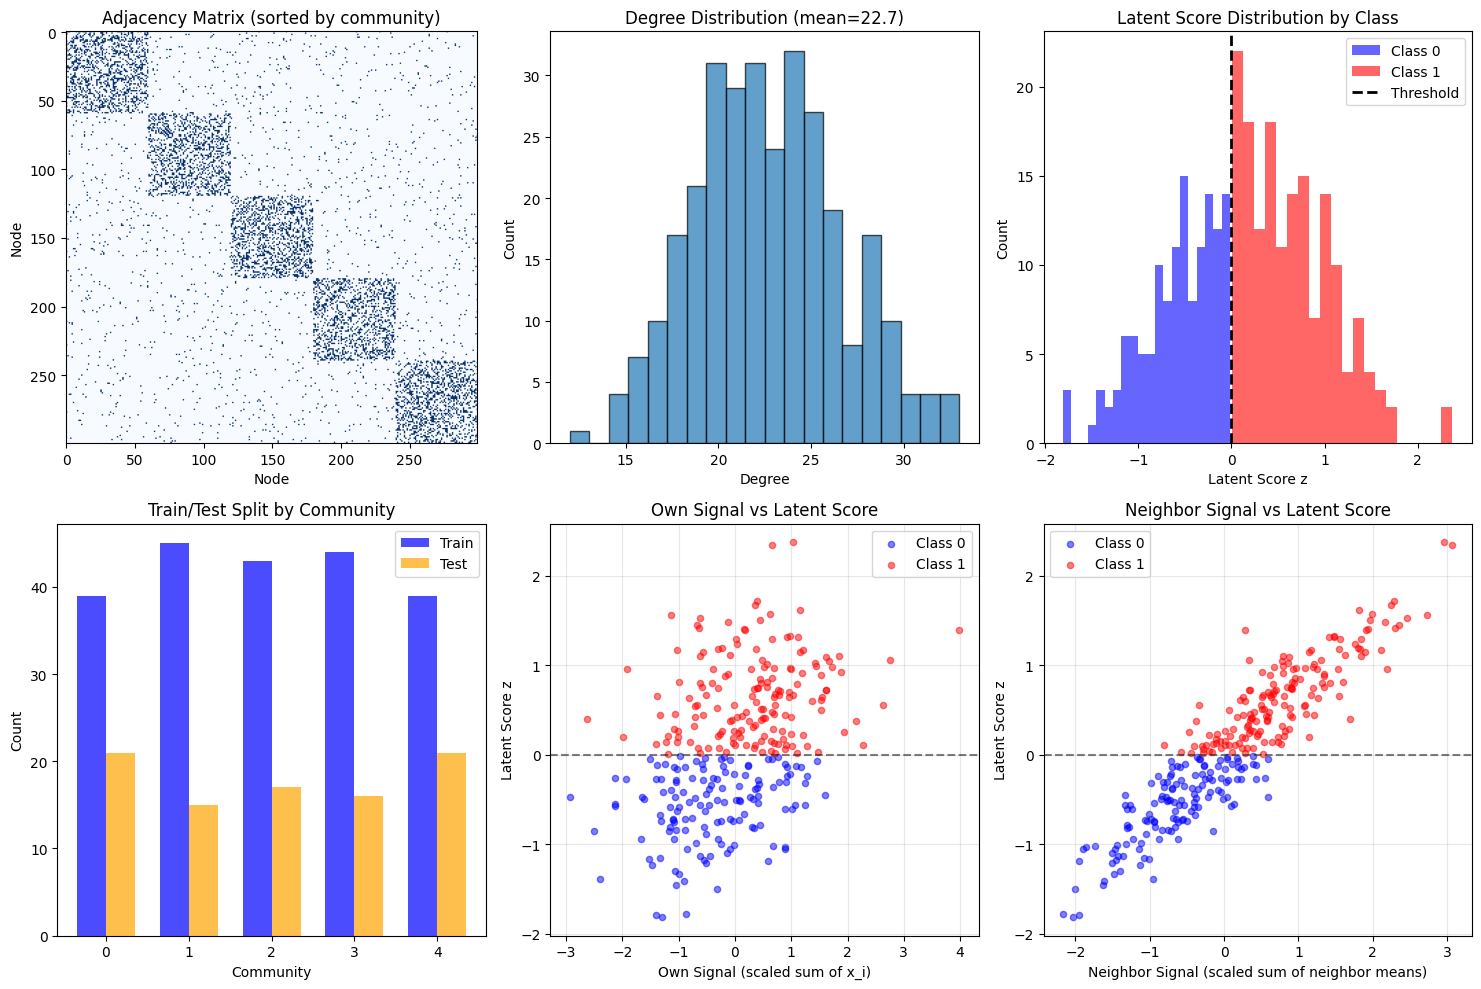


Signal Analysis:
  Correlation(own_signal, latent_score): 0.4026
  Correlation(neighbor_signal, latent_score): 0.9198


In [5]:
# Visualize the data
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Adjacency matrix (sorted by community)
ax = axes[0, 0]
sort_idx = np.argsort(data['community_labels'])
sorted_adj = data['adj_matrix'][sort_idx][:, sort_idx]
ax.imshow(sorted_adj, cmap='Blues')
ax.set_title('Adjacency Matrix (sorted by community)')
ax.set_xlabel('Node')
ax.set_ylabel('Node')

# Degree distribution
ax = axes[0, 1]
ax.hist(data['degree'], bins=20, alpha=0.7, edgecolor='black')
ax.set_xlabel('Degree')
ax.set_ylabel('Count')
ax.set_title(f'Degree Distribution (mean={data["degree"].mean():.1f})')

# Latent score distribution by class
ax = axes[0, 2]
ax.hist(data['z'][data['y']==0], bins=20, alpha=0.6, label='Class 0', color='blue')
ax.hist(data['z'][data['y']==1], bins=20, alpha=0.6, label='Class 1', color='red')
ax.axvline(x=0, color='black', linestyle='--', linewidth=2, label='Threshold')
ax.set_xlabel('Latent Score z')
ax.set_ylabel('Count')
ax.set_title('Latent Score Distribution by Class')
ax.legend()

# Train/test node distribution by community
ax = axes[1, 0]
communities = data['community_labels']
n_communities = len(np.unique(communities))
train_counts = [np.sum((communities == c) & train_mask) for c in range(n_communities)]
test_counts = [np.sum((communities == c) & test_mask) for c in range(n_communities)]
x_pos = np.arange(n_communities)
width = 0.35
ax.bar(x_pos - width/2, train_counts, width, label='Train', color='blue', alpha=0.7)
ax.bar(x_pos + width/2, test_counts, width, label='Test', color='orange', alpha=0.7)
ax.set_xlabel('Community')
ax.set_ylabel('Count')
ax.set_title('Train/Test Split by Community')
ax.legend()
ax.set_xticks(x_pos)

# Own signal vs class
ax = axes[1, 1]
ax.scatter(data['own_signal'][data['y']==0], data['z'][data['y']==0], 
           alpha=0.5, c='blue', s=20, label='Class 0')
ax.scatter(data['own_signal'][data['y']==1], data['z'][data['y']==1], 
           alpha=0.5, c='red', s=20, label='Class 1')
ax.axhline(y=0, color='black', linestyle='--', alpha=0.5)
ax.set_xlabel('Own Signal (scaled sum of x_i)')
ax.set_ylabel('Latent Score z')
ax.set_title('Own Signal vs Latent Score')
ax.legend()
ax.grid(True, alpha=0.3)

# Neighbor signal vs class
ax = axes[1, 2]
ax.scatter(data['neighbor_signal'][data['y']==0], data['z'][data['y']==0], 
           alpha=0.5, c='blue', s=20, label='Class 0')
ax.scatter(data['neighbor_signal'][data['y']==1], data['z'][data['y']==1], 
           alpha=0.5, c='red', s=20, label='Class 1')
ax.axhline(y=0, color='black', linestyle='--', alpha=0.5)
ax.set_xlabel('Neighbor Signal (scaled sum of neighbor means)')
ax.set_ylabel('Latent Score z')
ax.set_title('Neighbor Signal vs Latent Score')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Correlation analysis
corr_own = np.corrcoef(data['own_signal'], data['z'])[0, 1]
corr_neigh = np.corrcoef(data['neighbor_signal'], data['z'])[0, 1]
print(f"\nSignal Analysis:")
print(f"  Correlation(own_signal, latent_score): {corr_own:.4f}")
print(f"  Correlation(neighbor_signal, latent_score): {corr_neigh:.4f}")

## 2. Models

We compare:
1. **Logistic Regression**: Linear baseline, uses only node features
2. **MLP**: Nonlinear baseline, uses only node features  
3. **GCN**: Graph Convolutional Network, aggregates neighbor features
4. **GAT**: Graph Attention Network, learns attention weights for neighbors

### Why GNN Should Win

- LogReg/MLP can only learn: $P(y_i=1) = \sigma(f(x_i))$
- They can capture the $\alpha \cdot \tilde{s}_i$ term (~16% of signal)
- But they **cannot** access neighbor features $x_j$

- GCN/GAT compute: $h_i = \text{Aggregate}(\{x_j : j \in \mathcal{N}(i) \cup \{i\}\})$
- They can learn both the own-feature and neighbor-feature components

In [6]:
class MLPClassifier(nn.Module):
    """MLP baseline for classification - ignores graph structure."""
    
    def __init__(self, input_dim: int, hidden_dim: int = 64, dropout: float = 0.1):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, 2)  # 2 classes
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x, edge_index=None):
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        return self.fc3(x)  # logits for 2 classes


class GCNClassifier(nn.Module):
    """Graph Convolutional Network for classification."""
    
    def __init__(self, input_dim: int, hidden_dim: int = 64, dropout: float = 0.1):
        super().__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.fc = nn.Linear(hidden_dim, 2)  # 2 classes
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = self.dropout(x)
        x = F.relu(self.conv2(x, edge_index))
        x = self.dropout(x)
        return self.fc(x)


class GATClassifier(nn.Module):
    """Graph Attention Network for classification."""
    
    def __init__(self, input_dim: int, hidden_dim: int = 64, heads: int = 4, dropout: float = 0.1):
        super().__init__()
        self.conv1 = GATConv(input_dim, hidden_dim // heads, heads=heads, dropout=dropout)
        self.conv2 = GATConv(hidden_dim, hidden_dim // heads, heads=heads, dropout=dropout)
        self.fc = nn.Linear(hidden_dim, 2)  # 2 classes
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x, edge_index):
        x = F.elu(self.conv1(x, edge_index))
        x = self.dropout(x)
        x = F.elu(self.conv2(x, edge_index))
        x = self.dropout(x)
        return self.fc(x)

In [7]:
def adj_to_edge_index(adj_matrix: np.ndarray) -> torch.Tensor:
    """Convert adjacency matrix to edge index format."""
    rows, cols = np.where(adj_matrix > 0)
    return torch.tensor(np.array([rows, cols]), dtype=torch.long)


def prepare_data_transductive(data_dict: Dict, train_mask: np.ndarray, test_mask: np.ndarray):
    """Prepare data for transductive learning (single graph, node masks)."""
    X = data_dict['X'].copy()
    y = data_dict['y'].copy()
    adj = data_dict['adj_matrix']
    
    # Fit scaler on TRAIN nodes only
    scaler = StandardScaler()
    X_train_only = X[train_mask]
    scaler.fit(X_train_only)
    X = scaler.transform(X)
    
    X_tensor = torch.tensor(X, dtype=torch.float32)
    y_tensor = torch.tensor(y, dtype=torch.long)  # Long for classification
    edge_index = adj_to_edge_index(adj)
    train_mask_tensor = torch.tensor(train_mask)
    test_mask_tensor = torch.tensor(test_mask)
    
    return X_tensor, y_tensor, edge_index, train_mask_tensor, test_mask_tensor, scaler


# Prepare data
X, y, edge_index, train_mask_t, test_mask_t, scaler = prepare_data_transductive(
    data, train_mask, test_mask
)

print(f"Full graph: {X.shape[0]} nodes, {X.shape[1]} features, {edge_index.shape[1]} edges")
print(f"Train mask: {train_mask_t.sum().item()} nodes")
print(f"Test mask: {test_mask_t.sum().item()} nodes")

Full graph: 300 nodes, 5 features, 6814 edges
Train mask: 210 nodes
Test mask: 90 nodes


## 3. Training and Evaluation

In [8]:
def train_classifier_transductive(model, X, y, edge_index, train_mask, n_epochs=300, lr=0.01, weight_decay=1e-4):
    """Train a PyTorch classifier using transductive learning."""
    optimizer = Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    criterion = nn.CrossEntropyLoss()
    history = []
    
    model.train()
    for epoch in range(n_epochs):
        optimizer.zero_grad()
        logits = model(X, edge_index)
        # Only compute loss on TRAIN nodes
        loss = criterion(logits[train_mask], y[train_mask])
        loss.backward()
        optimizer.step()
        history.append(loss.item())
    
    return history


def evaluate_classifier_transductive(model, X, y, edge_index, mask):
    """Evaluate classifier on a subset of nodes."""
    model.eval()
    with torch.no_grad():
        logits = model(X, edge_index)
        probs = F.softmax(logits, dim=1)[:, 1].numpy()  # P(class=1)
        preds = logits.argmax(dim=1).numpy()
    
    y_np = y.numpy()
    y_subset = y_np[mask.numpy()]
    pred_subset = preds[mask.numpy()]
    prob_subset = probs[mask.numpy()]
    
    return {
        'accuracy': accuracy_score(y_subset, pred_subset),
        'f1': f1_score(y_subset, pred_subset),
        'auc': roc_auc_score(y_subset, prob_subset),
        'y_true': y_subset,
        'y_pred': pred_subset,
        'y_prob': prob_subset
    }

In [9]:
# Train all models
INPUT_DIM = X.shape[1]
HIDDEN_DIM = 64
N_EPOCHS = 300

results = {}

# 1. Logistic Regression (no graph)
print("Training Logistic Regression...")
logreg = LogisticRegression(max_iter=1000, random_state=SEED)
X_np = X.numpy()
y_np = y.numpy()
logreg.fit(X_np[train_mask], y_np[train_mask])
logreg_pred = logreg.predict(X_np)
logreg_prob = logreg.predict_proba(X_np)[:, 1]
results['LogReg'] = {
    'train': {'accuracy': accuracy_score(y_np[train_mask], logreg_pred[train_mask])},
    'test': {
        'accuracy': accuracy_score(y_np[test_mask], logreg_pred[test_mask]),
        'f1': f1_score(y_np[test_mask], logreg_pred[test_mask]),
        'auc': roc_auc_score(y_np[test_mask], logreg_prob[test_mask]),
        'y_true': y_np[test_mask],
        'y_pred': logreg_pred[test_mask],
        'y_prob': logreg_prob[test_mask]
    }
}
print(f"  Train Acc: {results['LogReg']['train']['accuracy']:.4f}, Test Acc: {results['LogReg']['test']['accuracy']:.4f}")

# 2. MLP (no graph)
print("\nTraining MLP...")
torch.manual_seed(SEED)
mlp = MLPClassifier(INPUT_DIM, HIDDEN_DIM)
mlp_history = train_classifier_transductive(mlp, X, y, edge_index, train_mask_t, N_EPOCHS)
results['MLP'] = {
    'train': evaluate_classifier_transductive(mlp, X, y, edge_index, train_mask_t),
    'test': evaluate_classifier_transductive(mlp, X, y, edge_index, test_mask_t)
}
print(f"  Train Acc: {results['MLP']['train']['accuracy']:.4f}, Test Acc: {results['MLP']['test']['accuracy']:.4f}")

# 3. GCN
print("\nTraining GCN...")
torch.manual_seed(SEED)
gcn = GCNClassifier(INPUT_DIM, HIDDEN_DIM)
gcn_history = train_classifier_transductive(gcn, X, y, edge_index, train_mask_t, N_EPOCHS)
results['GCN'] = {
    'train': evaluate_classifier_transductive(gcn, X, y, edge_index, train_mask_t),
    'test': evaluate_classifier_transductive(gcn, X, y, edge_index, test_mask_t)
}
print(f"  Train Acc: {results['GCN']['train']['accuracy']:.4f}, Test Acc: {results['GCN']['test']['accuracy']:.4f}")

# 4. GAT
print("\nTraining GAT...")
torch.manual_seed(SEED)
gat = GATClassifier(INPUT_DIM, HIDDEN_DIM)
gat_history = train_classifier_transductive(gat, X, y, edge_index, train_mask_t, N_EPOCHS)
results['GAT'] = {
    'train': evaluate_classifier_transductive(gat, X, y, edge_index, train_mask_t),
    'test': evaluate_classifier_transductive(gat, X, y, edge_index, test_mask_t)
}
print(f"  Train Acc: {results['GAT']['train']['accuracy']:.4f}, Test Acc: {results['GAT']['test']['accuracy']:.4f}")

Training Logistic Regression...
  Train Acc: 0.7000, Test Acc: 0.5889

Training MLP...


  Train Acc: 1.0000, Test Acc: 0.5000

Training GCN...


  Train Acc: 0.8143, Test Acc: 0.7000

Training GAT...


  Train Acc: 0.9810, Test Acc: 0.8889


In [10]:
# Results summary
print("\n" + "="*80)
print("RESULTS SUMMARY")
print("="*80)
print(f"\nSignal: {ALPHA*100:.0f}% own features + {BETA*100:.0f}% neighbor features")
print(f"Baselines can only capture the {ALPHA*100:.0f}% own-feature component.")
print(f"GNNs can capture both components via message passing.\n")
print("-"*80)
print(f"{'Model':<10} {'Train Acc':>12} {'Test Acc':>12} {'Test F1':>12} {'Test AUC':>12} {'Uses Graph':>12}")
print("-"*80)

for name in ['LogReg', 'MLP', 'GCN', 'GAT']:
    r = results[name]
    uses_graph = 'Yes' if name in ['GCN', 'GAT'] else 'No'
    train_acc = r['train']['accuracy']
    test_acc = r['test']['accuracy']
    test_f1 = r['test']['f1']
    test_auc = r['test']['auc']
    print(f"{name:<10} {train_acc:>12.4f} {test_acc:>12.4f} {test_f1:>12.4f} {test_auc:>12.4f} {uses_graph:>12}")

print("-"*80)

# Compute improvement
baseline_best = max(results['LogReg']['test']['accuracy'], results['MLP']['test']['accuracy'])
gnn_best = max(results['GCN']['test']['accuracy'], results['GAT']['test']['accuracy'])
improvement = gnn_best - baseline_best

print(f"\nGNN improvement over best baseline: {improvement:+.4f} accuracy")
print(f"GNN best AUC: {max(results['GCN']['test']['auc'], results['GAT']['test']['auc']):.4f}")
print("="*80)


RESULTS SUMMARY

Signal: 30% own features + 70% neighbor features
Baselines can only capture the 30% own-feature component.
GNNs can capture both components via message passing.

--------------------------------------------------------------------------------
Model         Train Acc     Test Acc      Test F1     Test AUC   Uses Graph
--------------------------------------------------------------------------------
LogReg           0.7000       0.5889       0.6263       0.6607           No
MLP              1.0000       0.5000       0.4706       0.5424           No
GCN              0.8143       0.7000       0.6824       0.7773          Yes
GAT              0.9810       0.8889       0.8684       0.9653          Yes
--------------------------------------------------------------------------------

GNN improvement over best baseline: +0.3000 accuracy
GNN best AUC: 0.9653


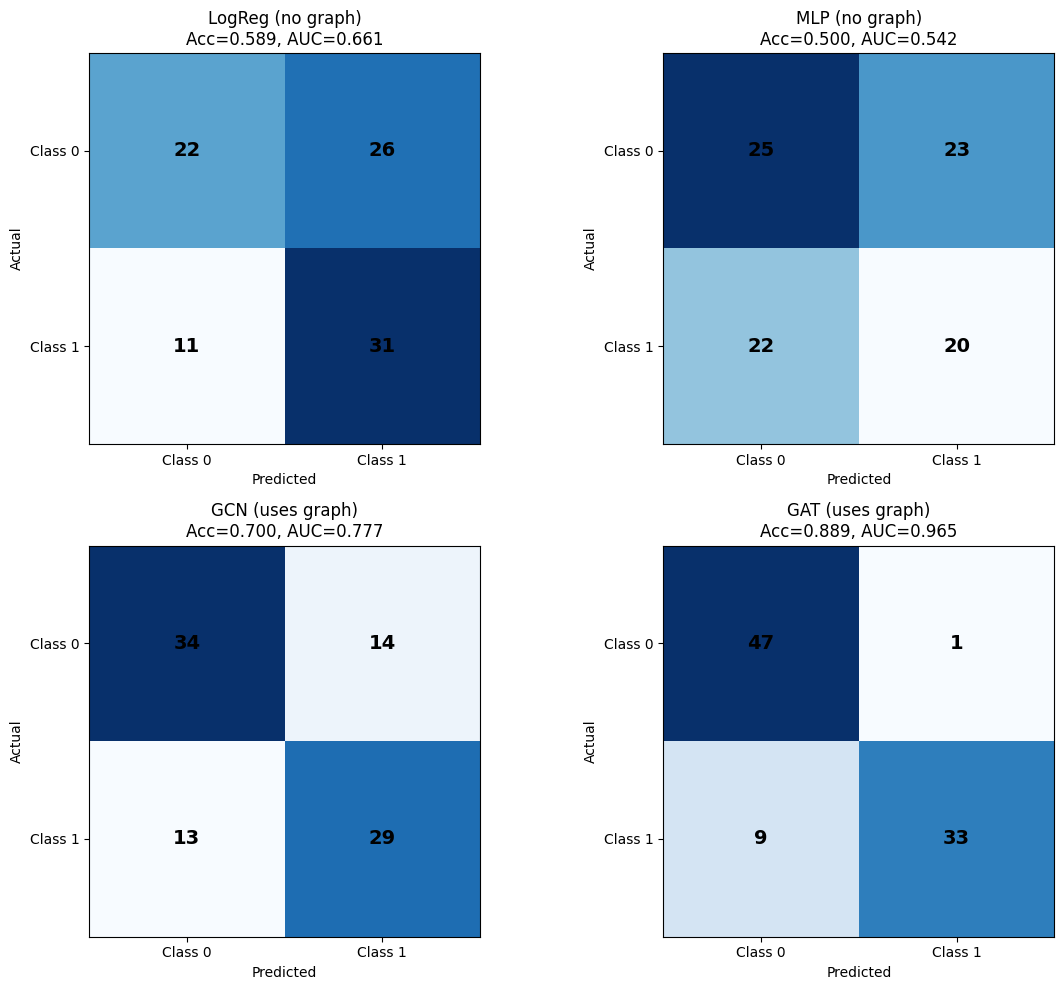

In [11]:
# Visualization: Confusion matrices
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

models = ['LogReg', 'MLP', 'GCN', 'GAT']
colors = ['gray', 'blue', 'green', 'orange']

for idx, (name, color) in enumerate(zip(models, colors)):
    ax = axes[idx // 2, idx % 2]
    
    y_true = results[name]['test']['y_true']
    y_pred = results[name]['test']['y_pred']
    
    cm = confusion_matrix(y_true, y_pred)
    im = ax.imshow(cm, cmap='Blues')
    
    # Add text annotations
    for i in range(2):
        for j in range(2):
            ax.text(j, i, str(cm[i, j]), ha='center', va='center', fontsize=14, fontweight='bold')
    
    acc = results[name]['test']['accuracy']
    auc = results[name]['test']['auc']
    uses_graph = '(uses graph)' if name in ['GCN', 'GAT'] else '(no graph)'
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    ax.set_title(f'{name} {uses_graph}\nAcc={acc:.3f}, AUC={auc:.3f}')
    ax.set_xticks([0, 1])
    ax.set_yticks([0, 1])
    ax.set_xticklabels(['Class 0', 'Class 1'])
    ax.set_yticklabels(['Class 0', 'Class 1'])

plt.tight_layout()
plt.show()

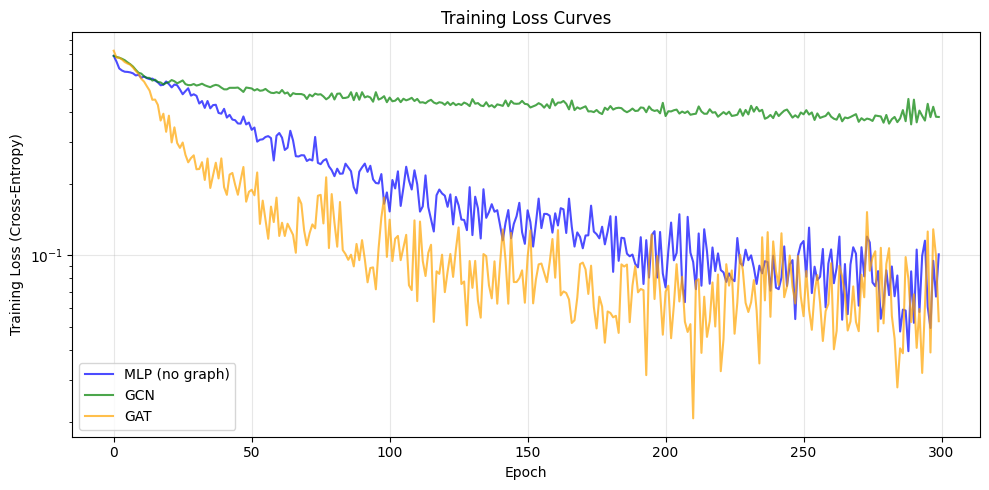

In [12]:
# Training curves
fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(mlp_history, label='MLP (no graph)', alpha=0.7, color='blue')
ax.plot(gcn_history, label='GCN', alpha=0.7, color='green')
ax.plot(gat_history, label='GAT', alpha=0.7, color='orange')

ax.set_xlabel('Epoch')
ax.set_ylabel('Training Loss (Cross-Entropy)')
ax.set_title('Training Loss Curves')
ax.legend()
ax.set_yscale('log')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 4. Ablation: Varying the Neighbor Signal Weight

Let's see how GNN advantage changes as we vary $\beta$ (neighbor weight):
- When $\beta = 0$: No neighbor signal → GNN has no advantage
- When $\beta = 1$: All neighbor signal → GNN has maximum advantage

In [13]:
# Ablation study: vary beta (using transductive learning)
betas = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]
ablation_results = []

print("Running ablation study over beta (neighbor weight)...\n")

for beta in betas:
    alpha = 1.0 - beta
    
    # Generate data with this alpha/beta
    data_abl = generate_dataset(n_nodes=300, n_features=5, alpha=alpha, beta=beta, seed=42)
    
    # Create train/test masks
    np.random.seed(42)
    indices = np.random.permutation(300)
    train_mask_abl = np.zeros(300, dtype=bool)
    test_mask_abl = np.zeros(300, dtype=bool)
    train_mask_abl[indices[:210]] = True
    test_mask_abl[indices[210:]] = True
    
    # Prepare data
    X_abl, y_abl, edge_abl, train_t, test_t, _ = prepare_data_transductive(
        data_abl, train_mask_abl, test_mask_abl
    )
    
    # Train LogReg (baseline)
    logreg = LogisticRegression(max_iter=1000, random_state=SEED)
    X_abl_np = X_abl.numpy()
    y_abl_np = y_abl.numpy()
    logreg.fit(X_abl_np[train_mask_abl], y_abl_np[train_mask_abl])
    logreg_pred = logreg.predict(X_abl_np)
    logreg_acc = accuracy_score(y_abl_np[test_mask_abl], logreg_pred[test_mask_abl])
    
    # Train GCN
    torch.manual_seed(SEED)
    gcn = GCNClassifier(X_abl.shape[1], 64)
    train_classifier_transductive(gcn, X_abl, y_abl, edge_abl, train_t, n_epochs=300)
    gcn_metrics = evaluate_classifier_transductive(gcn, X_abl, y_abl, edge_abl, test_t)
    
    ablation_results.append({
        'beta': beta,
        'alpha': alpha,
        'logreg_acc': logreg_acc,
        'gcn_acc': gcn_metrics['accuracy'],
        'improvement': gcn_metrics['accuracy'] - logreg_acc
    })
    
    print(f"beta={beta:.1f} (alpha={alpha:.1f}): LogReg Acc={logreg_acc:.4f}, GCN Acc={gcn_metrics['accuracy']:.4f}, "
          f"Delta={gcn_metrics['accuracy']-logreg_acc:+.4f}")

Running ablation study over beta (neighbor weight)...



beta=0.0 (alpha=1.0): LogReg Acc=0.9889, GCN Acc=0.7000, Delta=-0.2889


beta=0.2 (alpha=0.8): LogReg Acc=0.9222, GCN Acc=0.7444, Delta=-0.1778


beta=0.4 (alpha=0.6): LogReg Acc=0.8000, GCN Acc=0.7556, Delta=-0.0444


beta=0.6 (alpha=0.4): LogReg Acc=0.7111, GCN Acc=0.7556, Delta=+0.0444


beta=0.8 (alpha=0.2): LogReg Acc=0.5333, GCN Acc=0.6556, Delta=+0.1222


beta=1.0 (alpha=0.0): LogReg Acc=0.4889, GCN Acc=0.6556, Delta=+0.1667


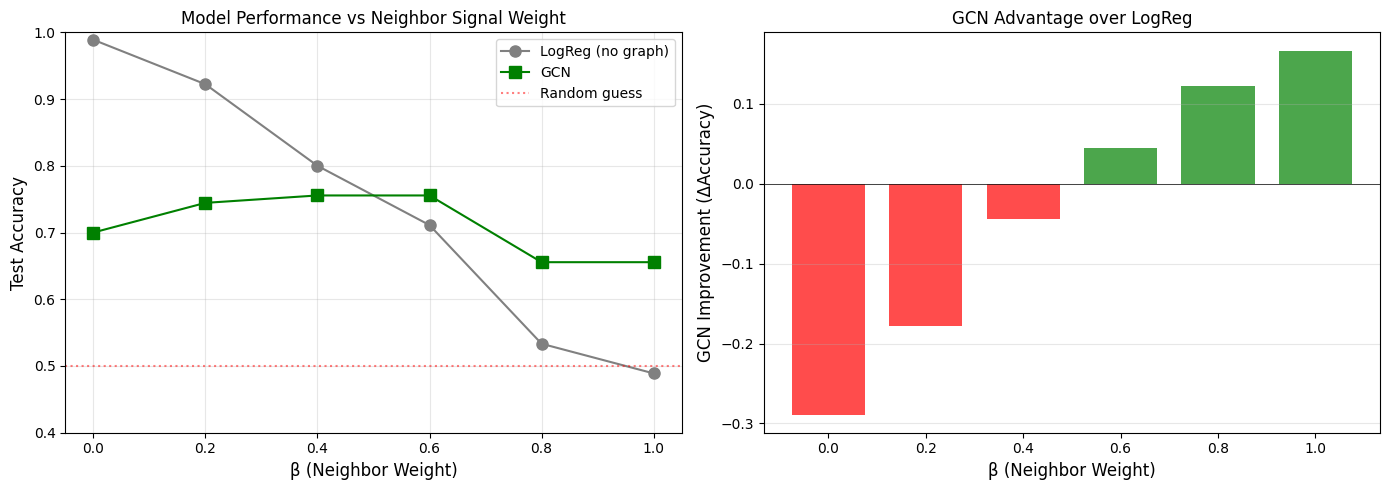


Key Insight:
- When beta=0 (no neighbor signal), GCN has no advantage
- As beta increases, GCN advantage grows because it can capture neighbor aggregation
- LogReg can only ever capture the alpha component (own features)


In [14]:
# Plot ablation results
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

betas_arr = [r['beta'] for r in ablation_results]
logreg_accs = [r['logreg_acc'] for r in ablation_results]
gcn_accs = [r['gcn_acc'] for r in ablation_results]
improvements = [r['improvement'] for r in ablation_results]

# Left: Accuracy vs beta
ax = axes[0]
ax.plot(betas_arr, logreg_accs, 'o-', label='LogReg (no graph)', color='gray', markersize=8)
ax.plot(betas_arr, gcn_accs, 's-', label='GCN', color='green', markersize=8)
ax.axhline(y=0.5, color='red', linestyle=':', alpha=0.5, label='Random guess')
ax.set_xlabel('β (Neighbor Weight)', fontsize=12)
ax.set_ylabel('Test Accuracy', fontsize=12)
ax.set_title('Model Performance vs Neighbor Signal Weight', fontsize=12)
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)
ax.set_xticks(betas_arr)
ax.set_ylim(0.4, 1.0)

# Right: Improvement vs beta
ax = axes[1]
colors = ['green' if imp > 0 else 'red' for imp in improvements]
ax.bar(betas_arr, improvements, color=colors, alpha=0.7, width=0.15)
ax.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
ax.set_xlabel('β (Neighbor Weight)', fontsize=12)
ax.set_ylabel('GCN Improvement (ΔAccuracy)', fontsize=12)
ax.set_title('GCN Advantage over LogReg', fontsize=12)
ax.grid(True, alpha=0.3, axis='y')
ax.set_xticks(betas_arr)

plt.tight_layout()
plt.show()

print("\nKey Insight:")
print("- When beta=0 (no neighbor signal), GCN has no advantage")
print("- As beta increases, GCN advantage grows because it can capture neighbor aggregation")
print("- LogReg can only ever capture the alpha component (own features)")

## 5. Summary

### What We Demonstrated

1. **Clear GNN advantage** when the class label depends on neighbor features
2. **Baseline limitation**: LogReg/MLP can only use own node features
3. **GNN capability**: GCN/GAT aggregate neighbor information via message passing

### The Key Formula

$$z_i = \underbrace{\alpha \cdot \tilde{s}_i}_{\text{Baselines can learn}} + \underbrace{\beta \cdot \tilde{h}_i}_{\text{Only GNN can learn}}, \quad y_i = \mathbf{1}[z_i > 0]$$

### Financial Applications

This setup models binary classification scenarios like:
- **Default prediction**: A company's default risk depends on counterparties' health
- **Fraud detection**: Fraudulent accounts cluster in transaction networks
- **Sector distress**: Whether a stock enters distress depends on sector peers
- **Credit contagion**: Credit events spread through connected entities

### When to Use GNNs for Classification

GNNs are most valuable when:
1. You have relational/network data
2. The class label depends on neighborhood structure
3. Information propagates through the network
4. You want to leverage homophily (similar nodes connect)